mu = 42.821, se = 0.024
mu = 12.402, se = 0.019
mu = 88.495, se = 0.236


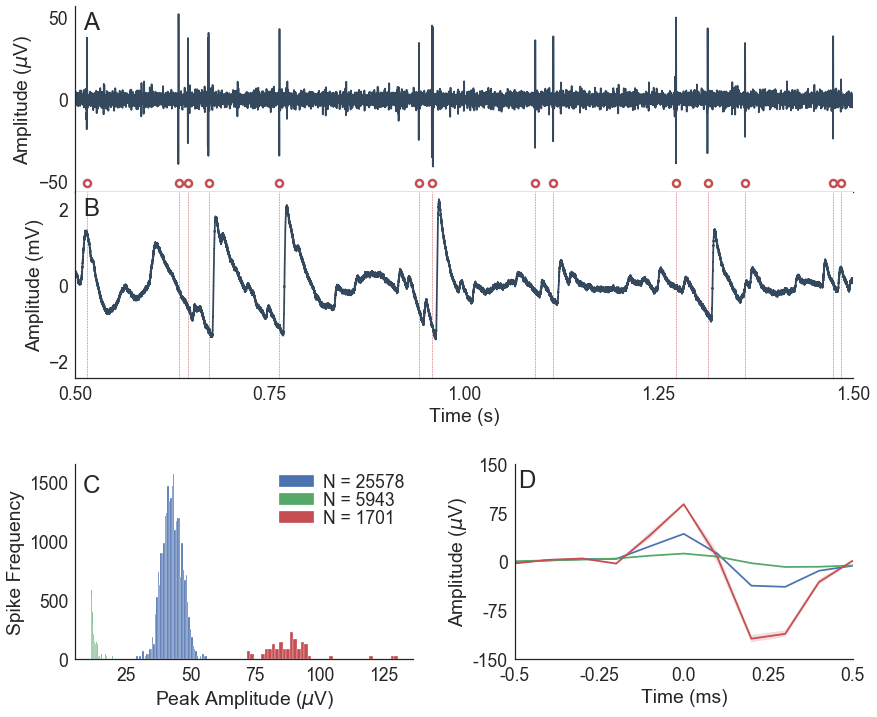

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Paired recording data.
npz = np.load('paired_recording.npz')
data = npz['data']
times = npz['times']
peak_times = npz['peak_times']

## Spike-sortking data.
df = read_csv('spike_sorting.csv')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,12))

## Initialize canvas for paired recording.
gs = gridspec.GridSpec(2, 1)
gs.update(left=0.05, right=0.95, bottom=0.45, hspace=0.00)

## Plot extracellular recording.
ax = plt.subplot(gs[0, 0])
ax.plot(times, data[0] * 1e6, color="#34495e")
y = np.max(np.abs(ax.get_ylim()))
ax.set(xlim=(times.min(), times.max()), xticks=[],
       ylim=(-y, y), yticks=[-50,0,50], ylabel=r'Amplitude ($\mu$V)')
ax.scatter(peak_times, np.ones_like(peak_loc)*-y*0.9, marker='o', 
           color='w', edgecolor='#c44e52', linewidth=2.5)
ax.text(0.51, y*0.95, 'A', fontsize=24, ha='left', va='top')

## Plot intracellular recording.
ax = plt.subplot(gs[1, 0])
ax.plot(times, data[1] * 1e3, color="#34495e")
y = np.max(np.abs(ax.get_ylim()))
ax.vlines(peak_times, -y, y, linestyle='--', lw=0.5, color='#c44e52')
ax.set(xlim=(times.min(), times.max()), xticks=np.linspace(times.min(), times.max(), 5), xlabel='Time (s)', 
       ylim=(-y, y), yticks=[-2.0,0.,2.], ylabel=r'Amplitude (mV)')
ax.text(0.51, y*0.95, 'B', fontsize=24, ha='left', va='top', zorder=20)

## Initialize canvas for spike sorting.
g2 = gridspec.GridSpec(1, 2)
g2.update(left=0.05, right=0.95, top=0.35, hspace=0.00, wspace=0.3)

## Plot histogram of spike magnitudes.
ax = plt.subplot(g2[0, 0])
for i in df.Category.unique():
    arr = df.loc[df.Category==i,'Peak Amplitude'] * 1e6
    sns.distplot(arr, kde=False, hist_kws=dict(alpha=1, edgecolor='w'), label='N = %s' %arr.shape[0])
    
    mu = arr.mean()
    se = arr.std () / np.sqrt(arr.size)
    print('mu = %0.3f, se = %0.3f' %(mu,se))
    
ax.set(xlabel=r'Peak Amplitude ($\mu$V)', ylabel='Spike Frequency')
ax.legend(loc=0, borderpad=0, labelspacing=0, handletextpad=0.5)
ax.text(8, ax.get_ylim()[1]*0.95, 'C', fontsize=24, ha='left', va='top')

## Plot timecourses of spikes.
ax = plt.subplot(g2[0, 1])
xticks = np.linspace(-0.5e-3,0.5e-3,5)
yticks = np.linspace(-150e-6,150e-6,5)

sns.tsplot(df, time='Sample', unit='Epoch', condition='Category', value='Voltage', 
           legend=False, ci=95, ax=ax)
ax.set(xlim=(xticks.min(), xticks.max()), xticks=xticks, xticklabels=xticks*1e3, xlabel='Time (ms)',
       yticks=yticks, yticklabels=(yticks*1e6).astype(int), ylabel='Amplitude ($\mu$V)')
ax.text(-0.49e-3, ax.get_ylim()[1]*0.95, 'D', fontsize=24, ha='left', va='top')

sns.despine()